## Speech Emotion Recognition

### Libraries :

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
import os
import random
from IPython.display import Audio
import librosa
import librosa.display as disp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Dense, Dropout , LSTM, TimeDistributed, Flatten , BatchNormalization
from tensorflow.keras.models import Sequential
from keras.layers import Conv1D

from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt



In [3]:
path ='/content/drive/MyDrive/Speech-Emotion-Recognition/speech_emotion/'

def load_data(path):
    f_emotions = []
    f_pathes = []
    folders = os.listdir(path)
    for folder in folders:
        files = os.listdir(path + folder)
        for file in files:
            step = file.split('.')[0]
            step = step.split('-')[2]
            f_emotions.append(int(step))
            f_pathes.append(path + folder + os.sep + file)
    return [f_emotions,f_pathes]

def get_emotion(number):

    info={1 : 'neutral',
          2 : 'calm' ,
          3 : 'happy',
          4 : 'sad',
          5 : 'angry',
          6 : 'fearful',
          7 : 'disgust',
          8 : 'surprised'}

    return info[number]

emotions, pathes = load_data(path)

In [4]:
def read_audio(path):
    data,sample_rate = librosa.load(path, duration = 2.4, offset=0.6)

    return data, sample_rate

def draw_wave(path,data, sr):
    plt.figure(figsize=(10,4))
    #data, sr = librosa.load(path)
    plt.title('Audio Wave : ' + path, size =12)
    disp.waveshow(data,sr=sr)
    plt.show()


def draw_spectogram(path,data, sr):
    plt.figure(figsize=(10,4))
    #data, sr = librosa.load(path)
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.title('spectogram for Wave : ' + path, size =12 )
    disp.specshow(Xdb,sr=sr, x_axis ='time', y_axis = 'hz')
    plt.show()


def add_noise(data,sr):
    noise = 0.035 * np.random.uniform()*np.amax(data)
    data+= noise * np.random.normal(size=data.shape[0])

    return data, sr

def shift(data,sr):
    shift_range = int(np.random.uniform(low=-5, high=5)*1000)
    shifted = np.roll(data,shift_range)

    return shifted,sr

def pitch(data,sr,factor=0.7):
    pitched = librosa.effects.pitch_shift(y=data, sr = sr , n_steps=factor)

    return pitched, sr


def stretch(data,sr, rate=0.55):
    stretched = librosa.effects.time_stretch(y=data, rate=rate)

    return stretched, sr

###  Extract Feature  MFCCs:

def feature_extraction(data,sr):
    mfcc = librosa.feature.mfcc(y=data, sr = sr)

    return mfcc

def processing_audio(data, sr, options):

    func = random.choice(options)

    if func == 'Standard':
        processed = data
    else:
        processed, _ = func(data,sr)
    return processed


20
happy


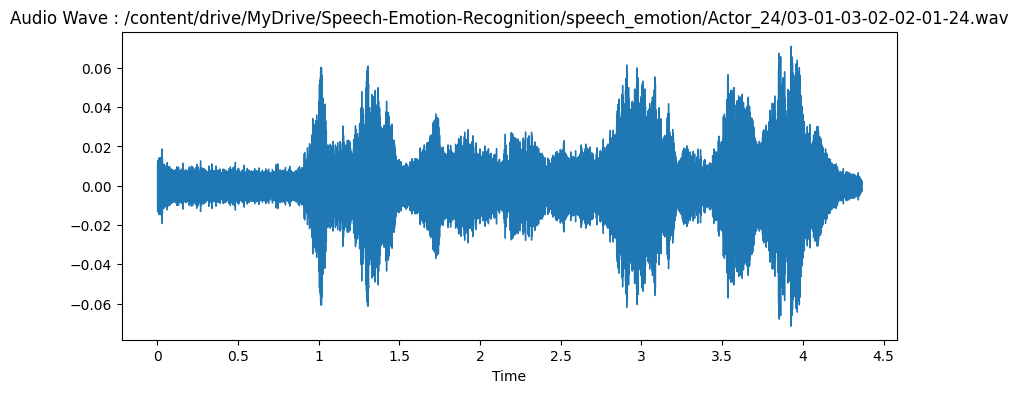

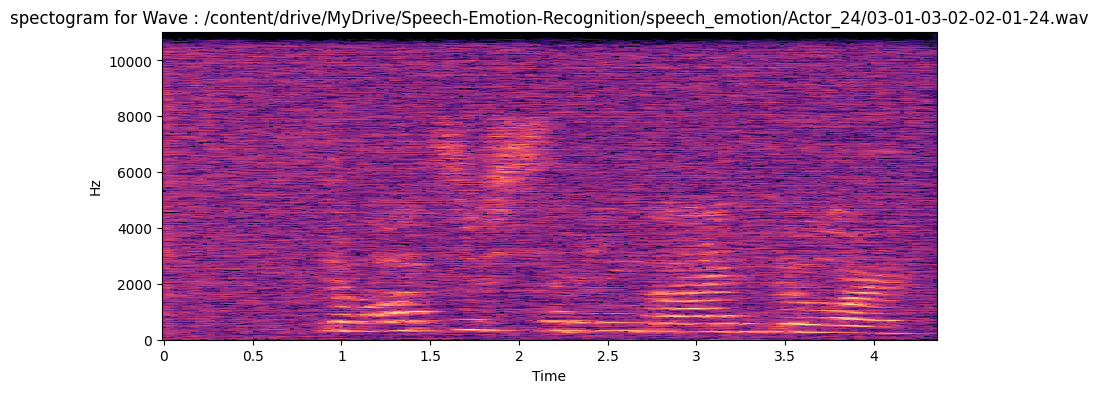

In [5]:
def get_features(path):

    data,sample_rate = read_audio(path)

    funcs=['Standard',add_noise,pitch]

    features=[]

    func1_data = processing_audio(data, sample_rate, funcs)
    func2_data = processing_audio(func1_data, sample_rate, funcs)

    feature =  feature_extraction(func2_data,sample_rate)
    #print(feature.shape)

    if feature.shape == (20,104):
        features.append(feature)

    func1_data = processing_audio(data, sample_rate, funcs)
    func2_data = processing_audio(func1_data, sample_rate, funcs)
    feature =  feature_extraction(func2_data,sample_rate)

    if feature.shape == (20,104):
        features.append(feature)

    func1_data = processing_audio(data, sample_rate, funcs)
    func2_data = processing_audio(func1_data, sample_rate, funcs)
    feature =  feature_extraction(func2_data,sample_rate)

    if feature.shape == (20,104):
        features.append(feature)

    return features


def display(number):

    data, sample_rate = read_audio(pathes[number])
    mfcc_features = feature_extraction(data, sample_rate)
    print(len(mfcc_features))

    print(get_emotion(emotions[number]))

    data, sample_rate = add_noise(data, sample_rate)
    data, sample_rate = shift(data, sample_rate)
    data, sample_rate = pitch(data, sample_rate)
    data, sample_rate = stretch(data, sample_rate)
    draw_wave(pathes[number], data, sample_rate)
    draw_spectogram(pathes[number], data, sample_rate)

    return data, sample_rate


d,sr = display(0)
Audio(data=d, rate=sr)

In [6]:
X = []
Y = []
for index in range(len(pathes)):
    value = get_features(pathes[index])
    if value != []:
        for item in value:
            X.append(item)
            Y.append(np.eye(8)[emotions[index] -1])#emotions

In [27]:
#for index in range(len(pathes)):
 #   print (get_emotion(emotions[index]))
#1, n_classes =8
#np.eye(8)[index -1] #0->7

encoder = OneHotEncoder()
encoder.fit_transform(np.array([1,2,3,4,5,6,7,8]).reshape(-1,1)).toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [8]:
x_train , x_test , y_train ,y_test = train_test_split(np.array(X), np.array(Y),
                                                     test_size =0.2, random_state=42, shuffle=True)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(213, 20, 104) (54, 20, 104)
(213, 8) (54, 8)


In [9]:
trainX = np.expand_dims(x_train, axis=3)
trainX = np.expand_dims(trainX, axis=3)
trainX = np.swapaxes(trainX, 1, 2)
print('trainX:' ,trainX.shape)


testX = np.expand_dims(x_test, axis=3)
testX  = np.expand_dims(testX , axis=3)
testX  = np.swapaxes(testX , 1, 2)
print('testX :' ,testX .shape)

inputShape = trainX.shape[1:]
inputShape

trainX: (213, 104, 20, 1, 1)
testX : (54, 104, 20, 1, 1)


(104, 20, 1, 1)

In [10]:
#Create model
def createModel(inputShape):
  model = Sequential()
  model.add(TimeDistributed(Conv1D(32,3, padding='same', activation='relu'), input_shape = inputShape))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(64))
  model.add(Dropout(0.2))

  model.add(Dense(units=64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units=64, activation='relu'))

  model.add(Dense(units=8, activation='softmax'))

  return model

In [11]:
model = createModel(inputShape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 104, 20, 1, 32)    128       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 104, 20, 1, 32)    128       
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 104, 640)          0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 64)                180480    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

### Training the model :

In [15]:
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss ='categorical_crossentropy',
              metrics =['accuracy'])

rlronp=ReduceLROnPlateau( monitor="val_loss", factor=0.6, patience=5, verbose=1, min_lr=0.001)
#earlystopper = EarlyStopping(monitor="val_loss", patience=8, verbose=1)
#reduc = ReduceLROnPlateau(monitor='val_loss', factor=0.6, verbose=1, patience=5, min_lr=1e-8)
#stop = EarlyStopping(monitor='val_loss',patience=7)
#, callbacks=[reduc,stop]

hist = model.fit(trainX, y_train, batch_size=140, epochs=80, validation_data=(testX,y_test),callbacks=[rlronp ])

Epoch 1/80
2/2 [==============================] - 6s 1s/step - loss: 1.0944 - accuracy: 0.6103 - val_loss: 1.8639 - val_accuracy: 0.2963 - lr: 0.0100
Epoch 2/80
2/2 [==============================] - 1s 502ms/step - loss: 0.9624 - accuracy: 0.6291 - val_loss: 2.5593 - val_accuracy: 0.2407 - lr: 0.0100
Epoch 3/80
2/2 [==============================] - 2s 778ms/step - loss: 0.9642 - accuracy: 0.6103 - val_loss: 2.2160 - val_accuracy: 0.2593 - lr: 0.0100
Epoch 4/80
2/2 [==============================] - 2s 972ms/step - loss: 0.7699 - accuracy: 0.7230 - val_loss: 1.5969 - val_accuracy: 0.4444 - lr: 0.0100
Epoch 5/80
2/2 [==============================] - 2s 809ms/step - loss: 0.8958 - accuracy: 0.6761 - val_loss: 1.4994 - val_accuracy: 0.4074 - lr: 0.0100
Epoch 6/80
2/2 [==============================] - 1s 547ms/step - loss: 0.8113 - accuracy: 0.6667 - val_loss: 1.6170 - val_accuracy: 0.3333 - lr: 0.0100
Epoch 7/80
2/2 [==============================] - 1s 499ms/step - loss: 0.7793 - accu

# Testing



2/2 [==============================] - 0s 72ms/step - loss: 1.3793 - accuracy: 0.7222
The accuracy:  72.22222089767456 %


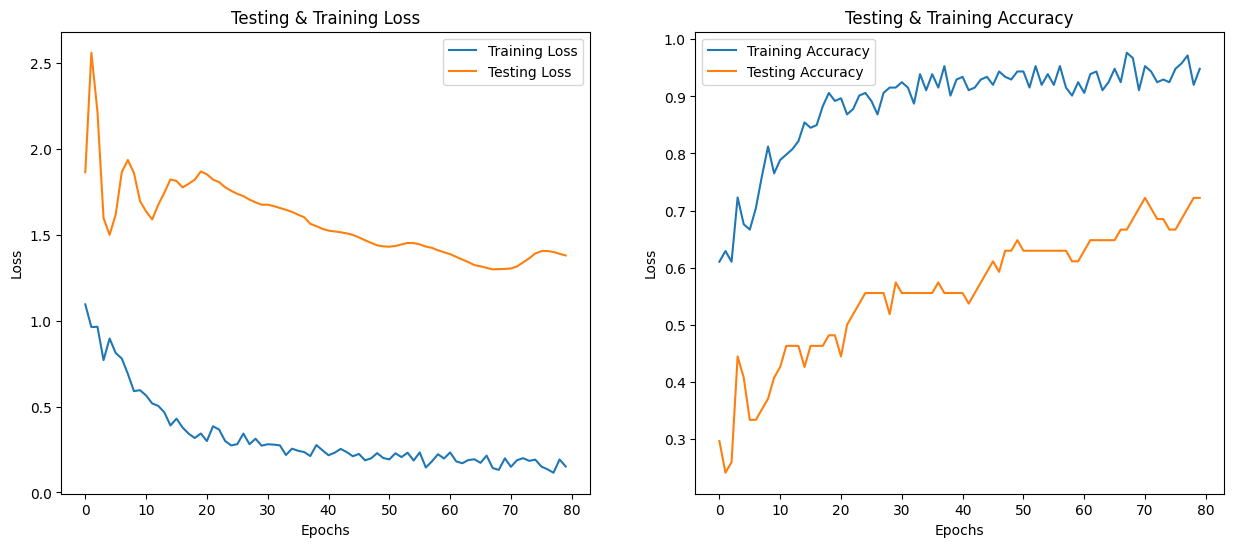

In [19]:
print('The accuracy: ', model.evaluate(testX,y_test)[1]*100, '%')

train_loss = hist.history['loss']
test_loss = hist.history['val_loss']
train_accuracy = hist.history['accuracy']
test_accuracy = hist.history['val_accuracy']


epochs = [value for value in range(80)]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Testing & Training Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(epochs, train_accuracy, label='Training Accuracy')
ax[1].plot(epochs, test_accuracy, label='Testing Accuracy')
ax[1].set_title('Testing & Training Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')


model.save('/content/drive/MyDrive/Speech-Emotion-Recognition/emotion_model.h5')

## Testing

In [24]:
emotion_model = load_model('/content/drive/MyDrive/Speech-Emotion-Recognition/emotion_model.h5')

y_pred = emotion_model.predict(testX)



2/2 [==============================] - 1s 39ms/step


In [36]:
predY = encoder.inverse_transform(y_pred)
testY = encoder.inverse_transform(y_test)
#get_emotion(predY.flatten()[0])

emotions_predict = [get_emotion(value) for value in predY.flatten()]
emotions_predict

emotions_actual = [get_emotion(value) for value in testY.flatten()]
emotions_actual

df = pd.DataFrame(columns=['Actual Emotions', 'Predicted Emotions'])

df['Actual Emotions']= emotions_actual
df['Predicted Emotions'] = emotions_predict

df.head(10)



,Actual Emotions,Predicted Emotions
0,angry,happy
1,calm,sad
2,calm,sad
3,happy,happy
4,surprised,surprised
5,calm,calm
6,calm,neutral
7,sad,sad
8,calm,calm
9,fearful,fearful


Text(0.5, 80.7222222222222, 'Predited Emotions')

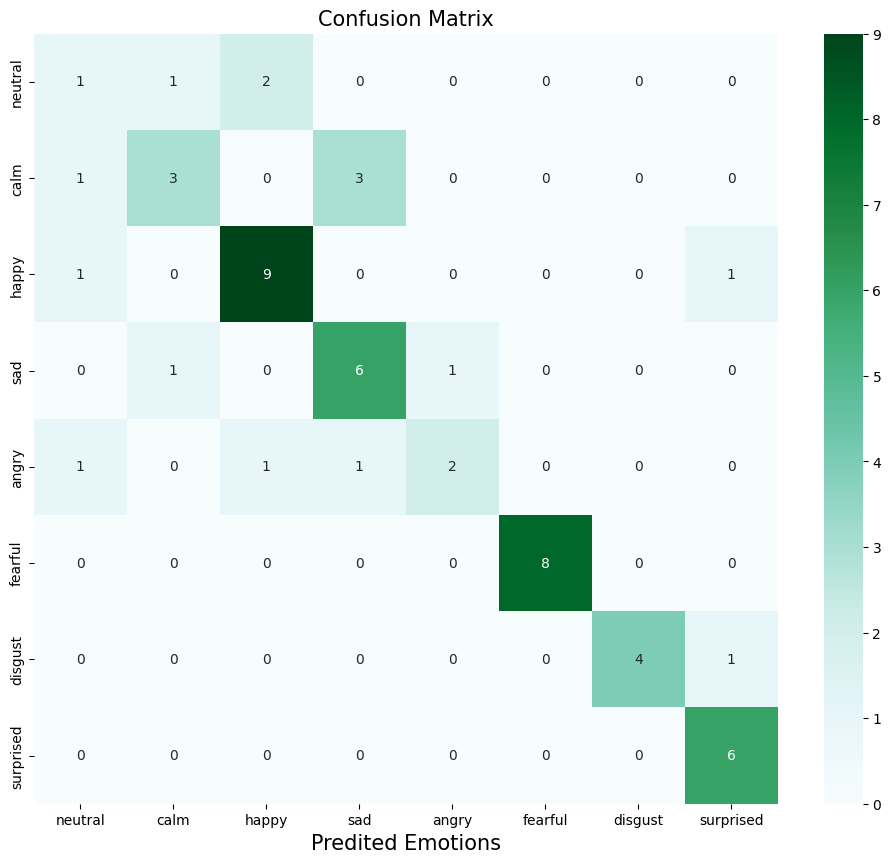

In [46]:
cm = confusion_matrix(testY,predY)

emts = [get_emotion(em) for em in encoder.categories_[0]]

cmt= pd.DataFrame(cm, index= emts, columns = emts)
plt.figure(figsize=(12,10))
sns.heatmap(cmt, annot=True, fmt='', cmap='BuGn')
plt.title('Confusion Matrix', size=15)
plt.xlabel('Predited Emotions' , size=15)
plt.ylabel('Actual Emotions' , size=15)

